## 第零部分 初始化

In [2]:
# import packages
import pandas as pd
import numpy as np

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
# read the file
df = pd.read_csv('../res/input1016.csv')

# print the head
df.head()

,xau,date,lag1,lag2,lag3,cbv,ccu,cfi2z,clq,ctv,...,lsu,ngq,rbq,sp500,tyvix,usd,usu,zcu,zsq,zwu
0,0.000000,1979/1/1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.353357,1979/1/2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.682500,1979/1/3,0.353357,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.060062,1979/1/4,-3.682500,0.353357,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.047597,1979/1/5,2.060062,-3.682500,0.353357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


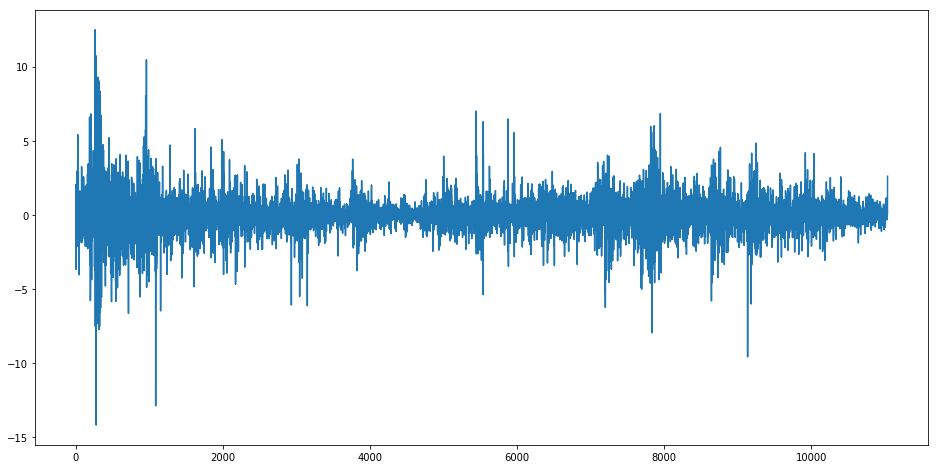

In [4]:
# setting index as date
# df['Ndate'] = pd.to_datetime(df.Ndate,format='%Y-%m-%d')
# df.index = df['Ndate']

# plot
plt.figure(figsize=(16,8))
plt.plot(df['xau'], label='Price History')

In [5]:
# splitting into train and validation
train = df[:5500].copy()
valid = df[5500:].copy()

df.shape, train.shape, valid.shape

((11039, 33), (5500, 33), (5539, 33))

## 第一部分 滑动平均

In [6]:
#make predictions
preds = []
for i in range(0,5539):
    a = train['xau'][len(train)-5539+i:].sum() + sum(preds)
    b = a/5539
    preds.append(b)
preds

[-0.001710422632785701,
 -0.001465017145627872,
 -0.0014384358322401902,
 -0.0014147990282741747,
 -0.0010771392348147548,
 -0.0007205519284841563,
 -0.0010683249349706131,
 -0.0012413698246501528,
 -0.0007676334398920105,
 -0.0007305540779927313,
 -0.0007462027747029666,
 -0.0007215042007319798,
 -0.000665634344837546,
 -0.0005751651394475546,
 -0.0007311749589347269,
 -0.0010391371038993298,
 -0.0010545792927608387,
 -0.0007627052424435903,
 -0.0007411343392557305,
 -0.0009479874171288582,
 -0.000911307794528593,
 -0.0009083980246774515,
 -0.0009177833415261026,
 -0.0009884897541170984,
 -0.001131965194585435,
 -0.0011473471960648692,
 -0.0012020884275499868,
 -0.0011082829260926025,
 -0.0008265303077365985,
 -0.0007709960694819922,
 -0.0006342927111265998,
 -0.0004366499804371481,
 -0.00023039742004365413,
 0.00019924136106845209,
 -5.530738523339062e-06,
 -0.00011510529922717067,
 1.061747901813945e-05,
 -9.583591320446065e-05,
 -2.172343024963206e-05,
 0.0039401203506800936,
 0.00

In [7]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['xau'])-preds),2)))
rms

1.004162729040933

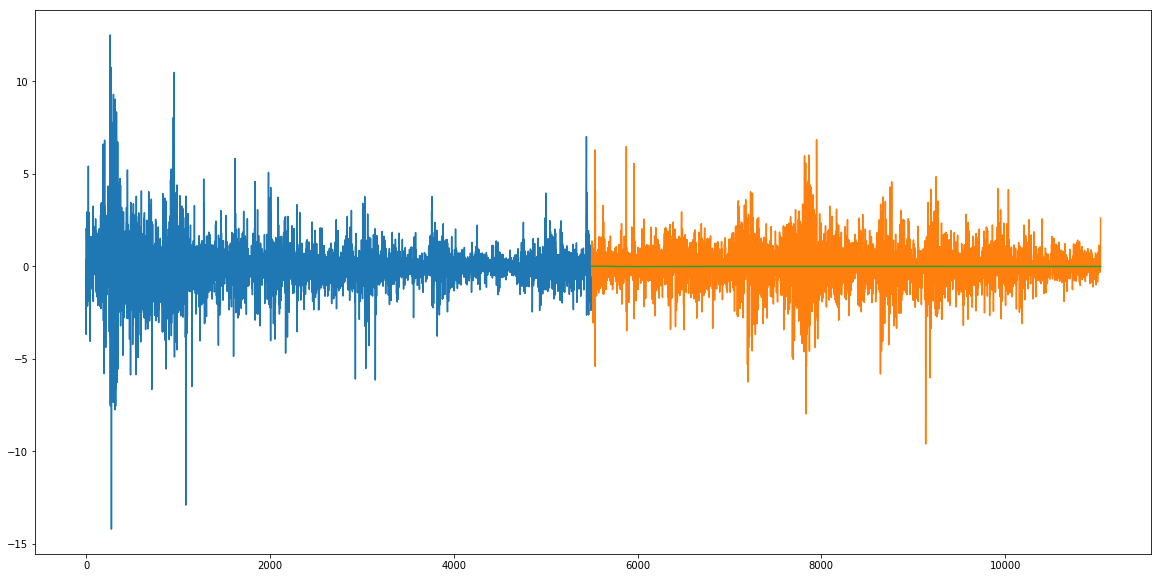

In [8]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['xau'])
plt.plot(valid[['xau', 'Predictions']])

## 第二部分 长短期记忆网络(LSTM)

In [11]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 

In [12]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['xau'])
for i in range(0,len(data)):
    new_data['xau'][i] = data['xau'][i]

In [14]:
#creating train and test sets
dataset = new_data.values
train = dataset[0:5500,:]
valid = dataset[5500:,:] 

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))

In [15]:
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

d:\visualstudio\shared\python36_64\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1024, batch_size=5, verbose=2)

W1107 15:15:12.450179  5804 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1107 15:15:12.480548  5804 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1107 15:15:12.486388  5804 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1107 15:15:13.135242  5804 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1107 15:15:13.501228  5804 deprecation.

Epoch 1/5
 - 79s - loss: 0.0038
Epoch 2/5
 - 77s - loss: 0.0025
Epoch 3/5
 - 79s - loss: 0.0025
Epoch 4/5
 - 77s - loss: 0.0025
Epoch 5/5
 - 70s - loss: 0.0024


In [17]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []

for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [18]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

1.0059785366999185

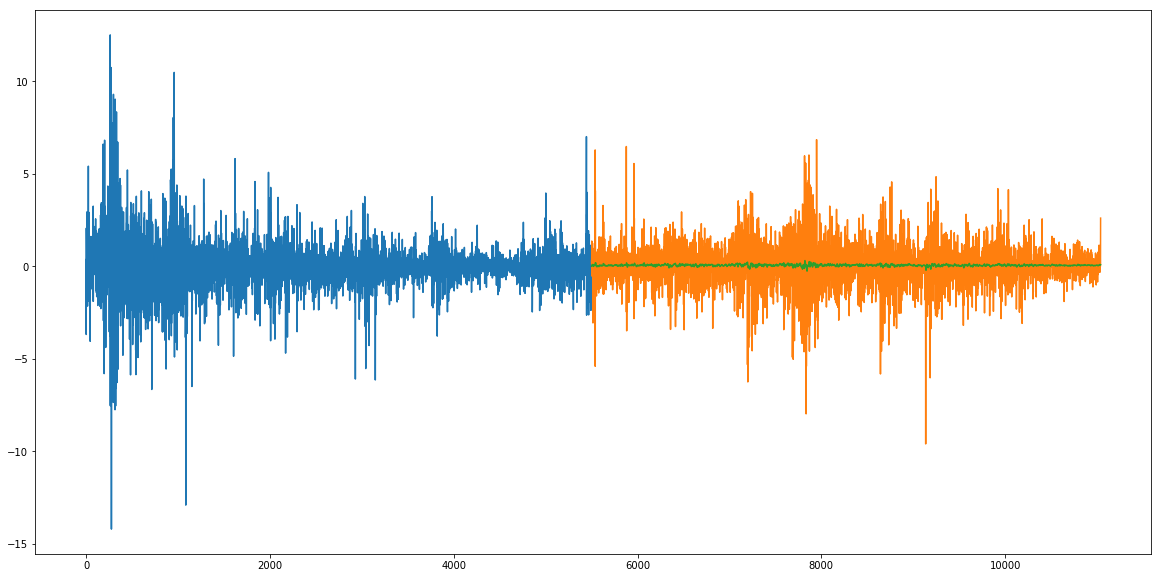

In [19]:
#for plotting
rcParams['figure.figsize'] = 20,10
train = new_data[:5500].copy()
valid = new_data[5500:].copy()
valid['Predictions'] = closing_price
plt.plot(train['xau'])
plt.plot(valid[['xau','Predictions']])

In [20]:
type(valid)

pandas.core.frame.DataFrame

In [21]:
valid.to_csv('LSTM_predict_v4.csv')

In [22]:
model.save('LSTM.model')

In [23]:
def LSTMPredict(input):
    keras.models.load_model('LSTM.model')# 加载保存下来的模型
    return model.predict(input)# 直接用加载出来的模型，对输入 input 进行预测

## 第三部分 神经网络

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
import keras as k
df = pd.read_csv('../res/input1017.csv')

In [25]:
df.head()

,lag1,lag2,lag3,cbv,ccu,cfi2z,clq,ctv,djci,dji,...,ngq,rbq,sp500,tyvix,usd,usu,zcu,zsq,zwu,Target
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.353357,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-3.682500,0.353357,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2.060062,-3.682500,0.353357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [26]:
Y_PRED = []
Y_TEST = []
accuracy = []
precision = []
recall = []
f1 = []
df = df.reindex(np.random.permutation(df.index))
# 黄金价格涨跌放在最后一列，列名叫‘Target’，涨和不变记为1，跌记为0
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [27]:
# 填参数的数目
num_parameters = 31

In [ ]:
# 十折
sfolder = StratifiedKFold(n_splits=10, shuffle=True, random_state=1218)
all_y_test = []
for train, test in sfolder.split(x, y):
    batch_size = 64
    max_epochs = 1024
    model = k.models.Sequential()
    # 每层神经元数可调
    model.add(k.layers.Dense(units=32, activation='relu', use_bias=True, input_shape=(num_parameters, )))
    model.add(k.layers.normalization.BatchNormalization(epsilon=1e-6))
    model.add(k.layers.Dense(units=32, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization())
    model.add(k.layers.Dense(units=32, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization(epsilon=1e-6))
    model.add(k.layers.Dense(units=32, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization())
    model.add(k.layers.Dropout(0.5))
    model.add(k.layers.Dense(units=2, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    x_train = x.iloc[train.tolist(), :]
    y_train = y.iloc[train.tolist()]
    model.fit(x_train, np_utils.to_categorical(y_train, num_classes=2), batch_size=batch_size, epochs=max_epochs, shuffle=True, verbose=1)
    x_test = x.iloc[test.tolist(), :]
    y_test = y.iloc[test.tolist()]
    y_test = y_test.reset_index()['Target']
    y_pred = model.predict(x_test)
    test_0_num = 0
    test_0_pred_0 = 0
    test_1_num = 0
    test_1_pred_1 = 0
    for index in range(0, len(y_test)):
        if y_test[index] == 0:
            test_0_num = test_0_num + 1
            if y_pred[index][0] < 0.5:
                test_0_pred_0 = test_0_pred_0 + 1
        else:
            test_1_num = test_1_num + 1
            if y_pred[index][1] > 0.5:
                test_1_pred_1 = test_1_pred_1 + 1
    accuracy = accuracy + [(test_1_pred_1 + test_0_pred_0) / (test_0_num + test_1_num)]
    precision = precision + [test_1_pred_1 / (test_1_pred_1 + test_0_num - test_0_pred_0)]
    recall = recall + [test_1_pred_1 / (test_1_pred_1 + test_0_pred_0)]

W1107 15:27:44.752460  5804 deprecation.py:506] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:3144: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/1024
9934/9934 [==============================] - 4s 355us/step - loss: 0.2823 - mean_absolute_error: 0.4637
Epoch 2/1024
9934/9934 [==============================] - 1s 67us/step - loss: 0.2441 - mean_absolute_error: 0.4347
Epoch 3/1024
9934/9934 [==============================] - 1s 66us/step - loss: 0.2295 - mean_absolute_error: 0.4223
Epoch 4/1024
9934/9934 [==============================] - 1s 70us/step - loss: 0.2202 - mean_absolute_error: 0.4164
Epoch 5/1024
9934/9934 [==============================] - 1s 65us/step - loss: 0.2132 - mean_absolute_error: 0.4102
Epoch 6/1024
9934/9934 [==============================] - 1s 66us/step - loss: 0.2097 - mean_absolute_error: 0.4091
Epoch 7/1024
9934/9934 [==============================] - 1s 66us/step - loss: 0.2072 - mean_absolute_error: 0.4051
Epoch 8/1024
9934/9934 [==============================] - 1s 76us/step - loss: 0.2058 - mean_absolute_error: 0.4041
Epoch 9/1024
9934/9934 [==============================] - 1s 151us/step

In [39]:
[accuracy, precision, recall]

[[0.43800904977375565,
  0.40452488687782806,
  0.40942028985507245,
  0.43568840579710144,
  0.36594202898550726,
  0.38768115942028986,
  0.4121376811594203,
  0.38168631006346326,
  0.41160471441523117,
  0.357207615593835,
  0.3844202898550725,
  0.399528900163073,
  0.3884057971014493,
  0.3841275593404602,
  0.4343891402714932,
  0.432579185520362,
  0.4375,
  0.46467391304347827,
  0.46557971014492755,
  0.4148550724637681,
  0.4121376811594203,
  0.39619220308250225,
  0.45602901178603805,
  0.40253853127833183],
 [0.4143049932523617,
  0.39095744680851063,
  0.3963494132985658,
  0.41263440860215056,
  0.36435124508519,
  0.37912813738441214,
  0.3968253968253968,
  0.3724696356275304,
  0.3948787061994609,
  0.356,
  0.37343834872351983,
  0.38163037409268563,
  0.3720472440944882,
  0.3649000868809731,
  0.4062947067238913,
  0.4072524407252441,
  0.4098591549295775,
  0.43059490084985835,
  0.4302158273381295,
  0.3917963224893918,
  0.3879310344827586,
  0.3786816269284712

In [40]:
y_output = []
y_1_num = 0
y_0_num = 0
for index in range(0, len(y_pred)):
        if y_pred[index][0] < 0.5:
            y_1_num = y_1_num + 1
            y_output.append(1)
        else:
            y_0_num = y_0_num + 1
            y_output.append(0)
y_1_num,y_0_num

(444, 659)

In [41]:
test_1_num,test_0_num

(493, 610)

In [42]:
y_pred

array([[0.11393404, 0.88606596],
       [0.20004305, 0.7999569 ],
       [0.174061  , 0.825939  ],
       ...,
       [0.99014753, 0.00985252],
       [0.60899013, 0.39100984],
       [0.99465054, 0.00534949]], dtype=float32)

In [43]:
comp_df = pd.DataFrame(y_test)
comp_df['Out'] = pd.DataFrame(y_output)
comp_df.to_csv('test_vs_out3.csv')

In [ ]:
model.save('4NN.model')#保存模型

In [ ]:
mport keras as k

def ModelPredict(input):
    k.models.load_model('4NN.model')# 加载保存下来的模型
    return model.predict(input)# 直接用加载出来的模型，对输入 input 进行预测